<a href="https://colab.research.google.com/github/everestso/Fall24Spring25/blob/main/c166DeepQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.7 MB/s eta 0:00:00


#Deep Learning Model

You can change a couple of hyper parameters in this model. I chose to change the # of epochs, increasing and decreasing gamma, increasing and decreasing epsilon decay, and the exploration rate.

In [72]:
import random, time
from collections import deque, namedtuple

import gymnasium as gym
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

from tqdm.auto import tqdm

n_episodes = 1000  # play 1000 games #Changed this
eps = 1.0  # exploration rate, probability of choosing random action # Changed this
eps_decay = 0.9975  # eps gets multiplied by this number each epoch... #Changed this
min_eps = 0.1  # ...until this minimum eps is reached
gamma = 0.95  # discount #Changed this
max_memory_size = 10000  # size of the replay memory
batch_size = 16  # batch size of the neural network training
min_length = 160  # minimum length of the replay memory for training, before it reached this length, no gradient updates happen
memory_parts = [
    "state",
    "action",
    "next_state",
    "reward",
    "done",
]  # nice names for the part of replay memory, otherweise the names are 0-5

Num GPUs Available:  0
Num CPUs Available:  1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Learning A Model

In [4]:
Memory = namedtuple("Memory", memory_parts)  # a single entry of the memory replay


class ReplayMemory:
    def __init__(self, max_length=None):
        self.max_length = max_length
        self.memory = deque(maxlen=max_length)

    def store(self, data):
        self.memory.append(data)

    def _sample(self, k):
        return random.sample(self.memory, k)

    def structured_sample(self, k):
        batch = self._sample(k)
        result = {}
        for i, part in enumerate(memory_parts):
            result[part] = np.array([row[i] for row in batch])

        return result

    def __len__(self):
        return len(self.memory)

In [5]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(4,)),  # Define input shape with Input layer
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(2, activation="linear"),  # 2 actions: go left or go right
    ]
)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [ ]:
env = gym.make("CartPole-v1")
replay_memory = ReplayMemory(max_length=max_memory_size)

for episode in tqdm(range(n_episodes)):  # tqdm makes a nice proress bar
    state, _ = env.reset()
    done = False

    while not done:
        if random.random() < eps:
            action = env.action_space.sample()  # random action
        else:
            action = model.predict(state[np.newaxis, :], verbose=False).argmax()  # best action according to the model

        next_state, reward, done, _, _ = env.step(action)
        memory = Memory(state, action, next_state, reward, done)
        replay_memory.store(memory)

        if len(replay_memory) >= min_length:
            batch = replay_memory.structured_sample(batch_size)  # get samples from the replay memory

            target_batch = batch["reward"] + gamma * model.predict(batch["next_state"], verbose=False).max(axis=1) * (
                1 - batch["done"]
            )  # R(s, a) + γ·maxₐ N(s') if not a terminal state, otherwise R(s, a)
            targets = model.predict(batch["state"], verbose=False)
            targets[
                range(batch_size), batch["action"]
            ] = target_batch  # set the target for the action that was done and leave the outputs of other 3 actions as they are

            model.fit(batch["state"], targets, verbose=False, batch_size=batch_size)  # train for one epoch

        state = next_state
    if episode % 100 == 0:
      save_path = '/content/drive/My Drive/model/my_QmodelB_{}iterations.keras'.format(episode)
      print (save_path)
      model.save(save_path)
    eps = max(min_eps, eps * eps_decay)
save_path = '/content/drive/My Drive/model/my_QmodelB_{}iterations.keras'.format(episode)
print (save_path)
model.save(save_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

/content/drive/My Drive/model/my_QmodelB_0iterations.keras
/content/drive/My Drive/model/my_QmodelB_100iterations.keras
/content/drive/My Drive/model/my_QmodelB_200iterations.keras
/content/drive/My Drive/model/my_QmodelB_300iterations.keras
/content/drive/My Drive/model/my_QmodelB_400iterations.keras
/content/drive/My Drive/model/my_QmodelB_500iterations.keras


In [73]:
eps_decay = 0.9975
min_eps = 0.01
eps = 0.5
for i in range(1000):
  eps = max(min_eps, eps * eps_decay)
  if (i % 10==0):
    print (i, eps)

print(eps)

0 0.49875
10 0.4864205923603105
20 0.4743959752825169
30 0.46266861415592797
40 0.45123116063007607
50 0.44007644801024964
60 0.4291974867668511
70 0.41858746015576587
80 0.4082397199469984
90 0.3981477822588998
100 0.38830532349537433
110 0.3787061763835228
120 0.36934432610923584
130 0.3602139065483192
140 0.35130919659078697
150 0.3426246165560207
160 0.334154724696549
170 0.3258942137882543
180 0.31783790780487275
190 0.3099807586747027
200 0.3023178431174884
210 0.29484435955949895
220 0.28755562512486793
230 0.2804470727013086
240 0.27351424807836716
250 0.2667528071564196
260 0.2601585132246642
270 0.2537272343064037
280 0.24745494056995324
290 0.24133770180355302
300 0.2353716849527022
310 0.22955315171837148
320 0.2238784562145894
330 0.21834404268393462
340 0.21294644326950252
350 0.2076822758419502
360 0.20254824188025827
370 0.19754112440488159
380 0.19265778596199354
390 0.1878951666575615
400 0.1832502822400207
410 0.17872022223034575
420 0.17430214809834807
430 0.1699932

# Test Learned Models

In [74]:
## Choose Model
version = 1
models = [(100, '1LGCBhWtOC2KAiUpXlC2vVTzR8Tfvl9iy'), (500, '1-DVCHfNfy_4U0Lp9oqzK4XatCZMvzZT_')] # Change based on the # of iterations

!gdown {models[version][1]}
save_path=f'my_QmodelB_{models[version][0]}iterations.keras'
print(save_path)

Downloading...
From: https://drive.google.com/uc?id=1-DVCHfNfy_4U0Lp9oqzK4XatCZMvzZT_
To: /content/my_QmodelB_500iterations.keras
100% 147k/147k [00:00<00:00, 104MB/s]
my_QmodelB_500iterations.keras


In [75]:
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf

from tensorflow.keras.models import load_model

model = load_model(save_path, compile=False)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

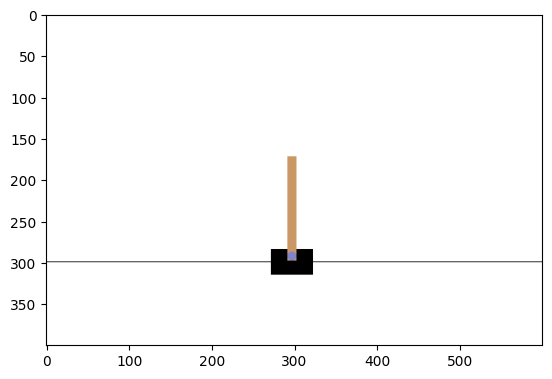

action=0, total_reward=1.0


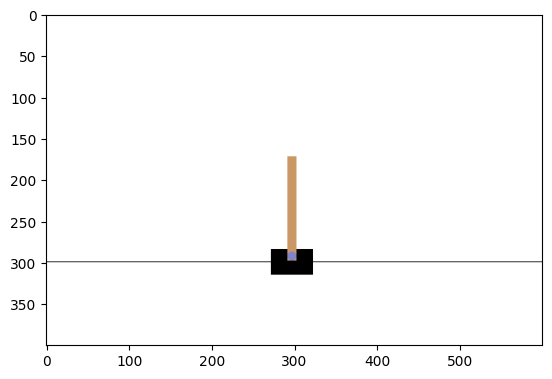

In [76]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
done = False
total_reward = 0
state_image=env.render()
plt.imshow(state_image)
plt.show()

state_image=env.render()
action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
state, reward, done, _, _ = env.step(action)
total_reward += reward
print (f"{action=}, {total_reward=}")
state_image=env.render()
plt.imshow(state_image)
plt.show()

In [77]:
env = gym.make("CartPole-v1", render_mode="human")

state, _ = env.reset()
done = False
total_reward = 0

while not done and total_reward < 500:  # force end the game after 500 time steps because the model is too good!
    env.render()
    action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
    state, reward, done, _, _ = env.step(action)
    total_reward += reward

env.close()
print (f"{total_reward=}")

total_reward=94.0


In [78]:
env.close()

#Discussion

 \# of epochs:
  - Increasing the epochs in this model will alway it to get a higher reward; however, I was unable to do this as increasing it from 1000 epochs will take forever. Therefore, I chose to decrease the number of epochs to 10. When decreasing the epochs to 10 and no other parameter was changed, I only got a total reward of 10. This shows that the reward dramatically decreases with few epochs as the model is not trained enough. I built the model only with 500 games as 1000 took way to long to do. With 500 games, the reward increased to 95

Gamma:
  - Increasing gamma from 0.95 to 0.99 changed the reward from 95 to 89. Decreasing gamma to 0.80 changed the reward very little. The reward decresed to 92


Epsilon decay:
- Decreasing the episolon decay to 0.995 results in epsilon converging to 0.01 by the 910th episode. Adittionally, the reward is 90. Intead of 95. Increasing it to 1 leaves the epsilon at 1 through all episodes and changes the reward to 90


Exploration rate:
- Increasing the exploration rate to 2.0 decreases the reward to 91 and by the 1000th episode, the epsilon is at 0.16. Decreasing the exploration rate to 0.5 decreases the reward to 89 and by the 1000th episode, the epsilon is at 0.04